<a href="https://colab.research.google.com/github/DanielhCarranza/Machine-Learning-in-Healthcare/blob/master/ECG_Signal_Classifier_with_Wavelet_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wavelet Transform. ECG Signal Classifier

## How does the Wavelet Transform work?
The Fourier Transform uses a series of sine-waves with different frequencies to analyze a signal. That is, a signal is represented through a linear combination of sine-waves.
The Wavelet Transform uses a series of functions called wavelets, each with a different scale. The word wavelet means a small wave, and this is exactly what a wavelet is.

![alt text](http://ataspinar.com/wp-content/uploads/2018/07/Wavelet-Out1.jpg)


we can see the difference between a sine-wave and a wavelet. The main difference is that the sine-wave is not localized in time (it stretches out from -infinity to +infinity) while a wavelet is localized in time. This allows the wavelet transform to obtain time-information in addition to frequency information.

Since the Wavelet is localized in time, we can multiply our signal with the wavelet at different locations in time. We start with the beginning of our signal and slowly move the wavelet towards the end of the signal. This procedure is also known as a convolution. After we have done this for the original (mother) wavelet, we can scale it such that it becomes larger and repeat the process. This process is illustrated in the figure below.


References:
* [Wavelet Transform in Machine Learning](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)
* [Github](https://github.com/taspinar/siml)

In [ ]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import scipy.io as sio
import scipy

from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier

In [ ]:
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


Each type of wavelets has a different shape, smoothness and compactness and is useful for a different purpose. Since there are only two mathematical conditions a wavelet has to satisfy it is easy to generate a new type of wavelet.

The two mathematical conditions are the so-called normalization and orthogonalization constraints:

A wavelet must have 
* **finite energy **
* **zero mean.**

*Finite energy* means that it is localized in time and frequency; it is integrable and the inner product between the wavelet and the signal always exists.
The admissibility condition implies a wavelet has zero mean in the time-domain, a zero at zero frequency in the time-domain. This is necessary to ensure that it is integrable and the inverse of the wavelet transform can also be calculated.

In [ ]:
pywt.Wavelet?

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


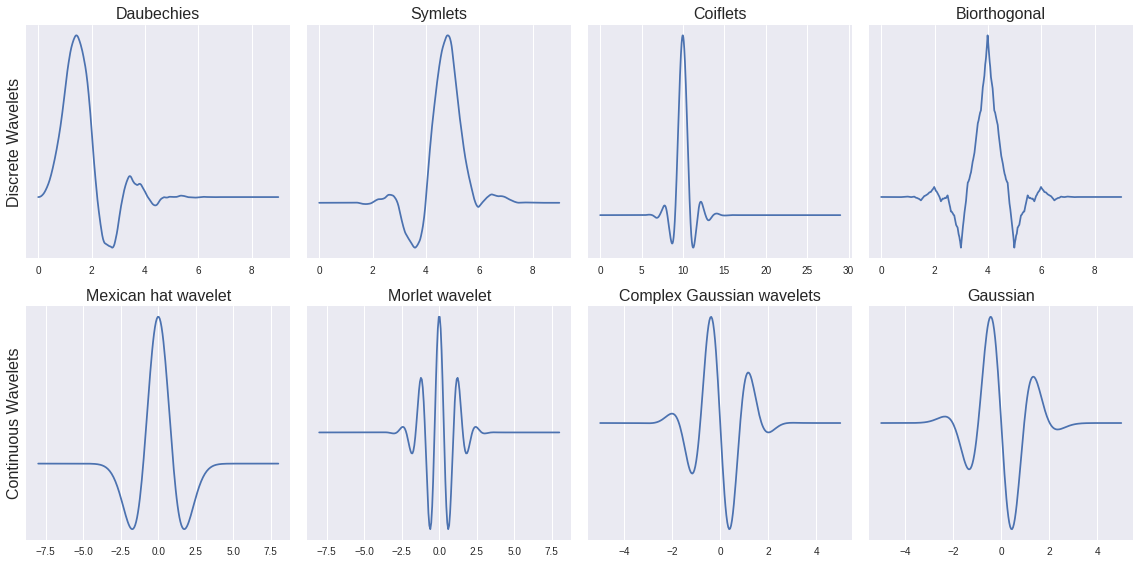

In [ ]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
 
plt.tight_layout()
plt.show()

In practice, the DWT is always implemented as a filter-bank. This means that it is implemented as a cascade of high-pass and low-pass filters. This is because filter banks are a very efficient way of splitting a signal of into several frequency sub-bands.
Below I will try to explain the concept behind the filter-bank in a simple (and probably oversimplified) way. It is necessary in order to understand how the wavelet transform actually works and can be used in practical applications.

 

To apply the DWT on a signal, we start with the smallest scale. As we have seen before, small scales correspond with high frequencies. This means that we first analyze high frequency behavior. At the second stage, the scale increases with a factor of two (the frequency decreases with a factor of two), and we are analyzing behavior around half of the maximum frequency. At the third stage, the scale factor is four and we are analyzing frequency behavior around a quarter of the maximum frequency. And this goes on and on, until we have reached the maximum decomposition level.

What do we mean with maximum decomposition level?  To understand this we should also know that at each subsequent stage the number of samples in the signal is reduced with a factor of two. At lower frequency values, you will need less samples to satisfy the Nyquist rate so there is no need to keep the higher number of samples in the signal; it will only cause the transform to be computationally expensive. Due to this downsampling, at some stage in the process the number of samples in our signal will become smaller than the length of the wavelet filter and we will have reached the maximum decomposition level.

To give an example, suppose we have a signal with frequencies up to 1000 Hz. In the first stage we split our signal into a low-frequency part and a high-frequency part, i.e. 0-500 Hz and 500-1000 Hz.
At the second stage we take the low-frequency part and again split it into two parts: 0-250 Hz and 250-500 Hz.
At the third stage we split the 0-250 Hz part into a 0-125 Hz part and a 125-250 Hz part.
This goes on until we have reached the level of refinement we need or until we run out of samples.

We can easily visualize this idea, by plotting what happens when we apply the DWT on a chirp signal. A chirp signal is a signal with a dynamic frequency spectrum; the frequency spectrum increases with time. The start of the signal contains low frequency values and the end of the signal contains the high frequencies. This makes it easy for us to visualize which part of the frequency spectrum is filtered out by simply looking at the time-axis.

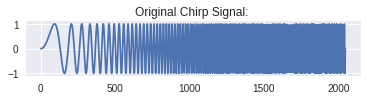

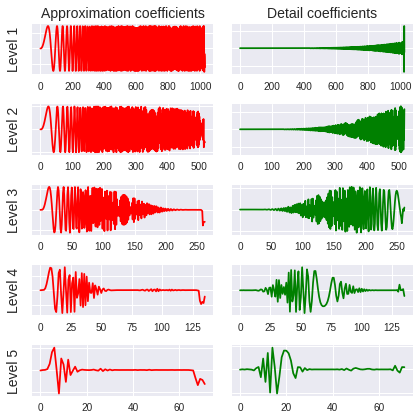

In [ ]:
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [ ]:
chirp_signal.shape

(2048,)

The approximation and detail coefficients of the sym5 wavelet (level 1 to 5) applied on a chirp signal, from level 1 to 5. On the left we can see a schematic representation of the high pass and low pass filters applied on the signal at each level.
* The DWT return two sets of coefficients; the approximation coefficients and detail coefficients.
* The approximation coefficients represent the output of the low pass filter (averaging filter) of the DWT.
* The detail coefficients represent the output of the high pass filter (difference filter) of the DWT.
* By applying the DWT again on the approximation coefficients of the previous DWT, we get the wavelet transform of the next level.
* At each next level, the original signal is also sampled down by a factor of 2.

In [ ]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
    
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave
 
def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
 

In [ ]:

dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset, header=None)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
scales = np.arange(1, 128)

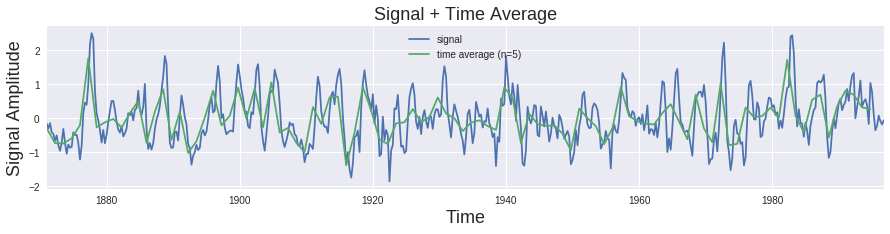

In [ ]:

plot_signal_plus_average(time, signal)

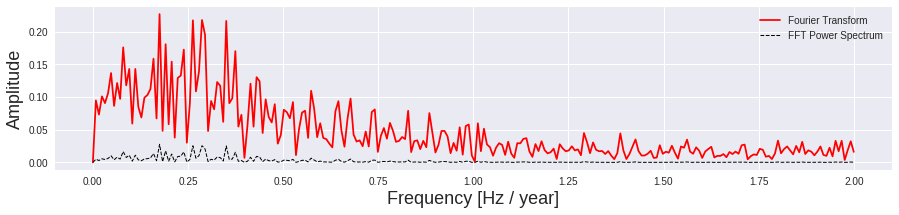

In [ ]:

plot_fft_plus_power(time, signal)

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:74: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


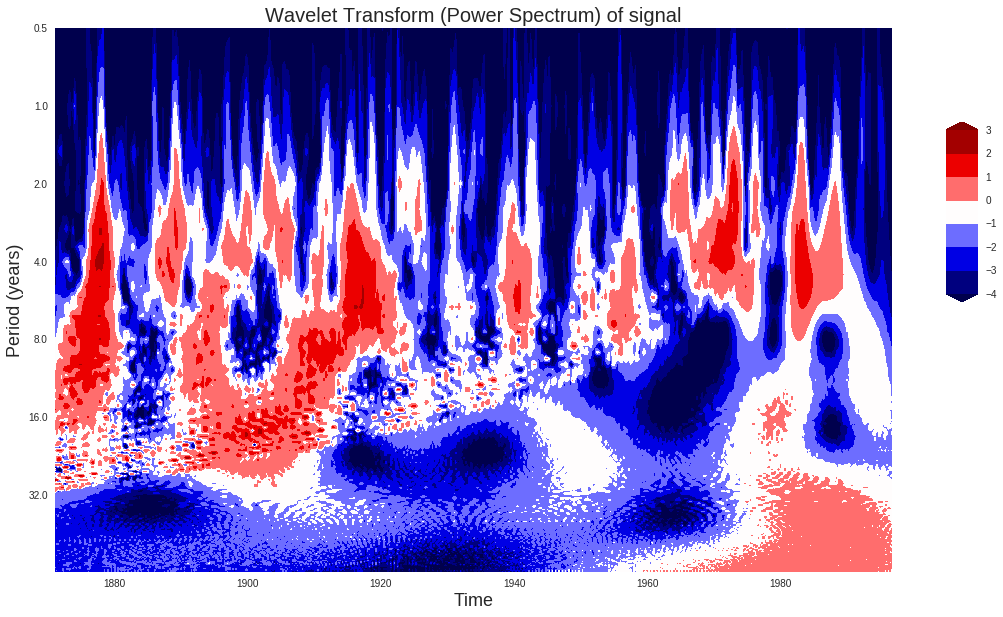

In [ ]:

plot_wavelet(time, signal, scales)

## Classification of signals using the CWT and CNN
we have seen that the wavelet transform of a 1D signal results in a 2D scaleogram which contains a lot more information than just the time-series or just the Fourier Transform. We have seen that applied on the el-Nino dataset, it can not only tell us what the period is of the largest oscillations, but also when these oscillations were present and when not.

Such a scaleogram can not only be used to better understand the dynamical behavior of a system, but it can also be used to distinguish different types of signals produced by a system from each other.
If you record a signal while you are walking up the stairs or down the stairs, the scaleograms will look different. ECG measurements of people with a healthy heart will have different scaleograms than ECG measurements of people with arrhythmia. Or measurements on a bearing, motor, rotor, ventilator, etc when it is faulty vs when it not faulty. The possibilities are limitless!

So by looking at the scaleograms we can distinguish a broken motor from a working one, a healthy person from a sick one, a person walking up the stairs from a person walking down the stairs, etc etc. But if you are as lazy as me, you probably don’t want to sift through thousands of scaleograms manually. One way to automate this process is to build a Convolutional Neural Network which can automatically detect the class each scaleogram belongs to and classify them accordingly.

In [ ]:
# Raw Data
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip
! unzip HAPT" "Data" "Set.zip

In [ ]:
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip
! unzip HAPT" "Data" "Set.zip

There are three main signal types in the raw data: total acceleration, body acceleration, and body gyroscope. Each has three axes of data. This means that there are a total of nine variables for each time step.

Further, each series of data has been partitioned into overlapping windows of 2.65 seconds of data, or 128 time steps. These windows of data correspond to the windows of engineered features (rows) in the previous section.

This means that one row of data has (128 * 9), or 1,152, elements. This is a little less than double the size of the 561 element vectors in the previous section and it is likely that there is some redundant data.

In [ ]:
# upload your kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

# download dataset 
! kaggle datasets download -d uciml/human-activity-recognition-with-smartphones
! unzip human-activity-recognition-with-smartphones.zip

 36% 9.00M/25.0M [00:00<00:00, 24.9MB/s]
100% 25.0M/25.0M [00:00<00:00, 50.8MB/s]
Archive:  human-activity-recognition-with-smartphones.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train=pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

data = pd.concat([train, test], axis=0).reset_index(drop=True)


In [ ]:
labels = data.iloc[:,-1]
data=data.drop(['subject','Activity'], axis=1)

In [ ]:
data.head()

## ECG classifier

In [ ]:
! wget https://github.com/mathworks/physionet_ECG_data/raw/master/ECGData.zip
! unzip ECGData.zip

In [ ]:
import scipy.io as sio
import scipy
from collections import defaultdict, Counter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier
from collections import Counter


In [ ]:
data=sio.loadmat('ECGData.mat')

In [ ]:
ecg_signals= pd.DataFrame(data['ECGData'][0][0][0])
ecg_labels= pd.Series(np.array(list(map(lambda x: str(x[0]), 
                                        np.squeeze(data['ECGData'][0][0][1])))), name='labels').astype('category')

ecg_data=pd.concat([ecg_labels, ecg_signals],axis=1)
# ecg_data.columns=range(0,len(ecg_data.iloc[0,:]))



In [ ]:

ecg_data.tail()

,labels,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
157,NSR,-0.075,-0.165,-0.225,-0.175,-0.225,-0.225,-0.215,-0.185,-0.235,...,-0.165,-0.265,-0.505,-0.315,0.575,1.775,1.315,-0.195,-0.725,-0.495
158,NSR,-0.185,-0.155,-0.145,-0.135,-0.105,-0.095,-0.095,-0.065,-0.055,...,0.105,0.105,0.155,0.125,0.175,0.155,0.185,0.225,0.225,0.155
159,NSR,-0.355,-0.355,-0.345,-0.335,-0.335,-0.345,-0.345,-0.375,-0.365,...,-0.125,-0.175,-0.225,-0.235,-0.275,-0.315,-0.355,-0.335,-0.315,-0.315
160,NSR,-0.275,-0.245,-0.285,-0.265,-0.235,-0.215,-0.165,-0.165,-0.145,...,0.015,-0.095,-0.075,-0.105,-0.145,-0.165,-0.165,-0.205,-0.145,-0.165
161,NSR,0.125,0.005,0.025,0.065,-0.085,0.005,-0.065,-0.015,-0.035,...,-0.245,-0.225,-0.245,-0.275,-0.295,-0.275,-0.275,-0.225,-0.275,-0.205


In [ ]:
def plot_ecg_signal(arr_type):
    
    
    signal=ecg_data[ecg_data['labels']==arr_type].iloc[0,1:]
    time=np.arange(0,len(signal),1)
    
    plt.plot(time[0:500],signal[0:500])
    plt.xlabel('Time')
    plt.ylabel('Amplitud')
    plt.title(f'{arr_type}')

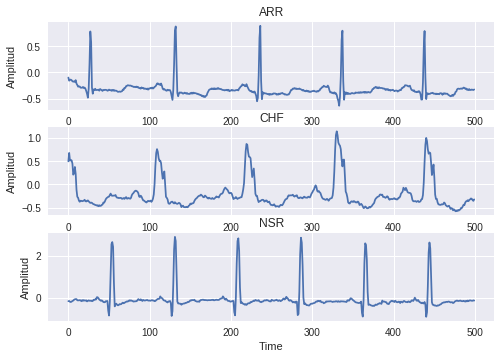

In [ ]:
plt.figure()
plt.subplot(311)
plot_ecg_signal('ARR')
plt.subplot(312)
plot_ecg_signal('CHF')
plt.subplot(313)
plot_ecg_signal('NSR')

### Classifier with Raw data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ecg_signals, ecg_labels, random_state=3)

In [ ]:
# Create the model =====  Too SLOWWWW ======
lgbm = LGBMClassifier(n_estimators=1000, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

In [ ]:
y_pred=lgbm.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(y_test, y_pred))

Accuracy on testset:	0.8049

              precision    recall  f1-score   support

         ARR       0.82      0.88      0.85        26
         CHF       0.50      0.25      0.33         4
         NSR       0.82      0.82      0.82        11

   micro avg       0.80      0.80      0.80        41
   macro avg       0.71      0.65      0.67        41
weighted avg       0.79      0.80      0.79        41



### Classifier with PCA

In [ ]:
# Scale data
scl = StandardScaler()
pca_data = scl.fit_transform(ecg_signals)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(pca_data)


# Encode labels 
enc = LabelEncoder()
label_encoded = enc.fit_transform(ecg_labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(pca_data, label_encoded, random_state=3)
print(X_train.shape)

(121, 71)


In [ ]:
# Create the model
lgbm = LGBMClassifier(n_estimators=2000, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

In [ ]:
y_pred=lgbm.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(y_test, y_pred))

Accuracy on testset:	0.8049

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.33      0.50      0.40         4
           2       1.00      0.82      0.90        11

   micro avg       0.80      0.80      0.80        41
   macro avg       0.73      0.72      0.72        41
weighted avg       0.84      0.80      0.82        41



### Feature engineering

In [ ]:
dict_ecg_data = defaultdict(list)
for ii, label in enumerate(ecg_labels.values):
    dict_ecg_data[label].append(ecg_signals.values[ii])

In [ ]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics
  
def get_ecg_features(ecg_data, ecg_labels, waveletname):
    list_features = []
    list_unique_labels = list(set(ecg_labels))
    list_labels = [list_unique_labels.index(elem) for elem in ecg_labels]
    for signal in ecg_data:
        list_coeff = pywt.wavedec(signal, waveletname)
        features = []
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
    return list_features, list_labels
  
def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test

In [ ]:
list_labels = []
list_features = []
for k, v in dict_ecg_data.items():
    yval = list(dict_ecg_data.keys()).index(k)
    for signal in v:
        features = []
        list_labels.append(yval)
        list_coeff = pywt.wavedec(signal, 'sym5')
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
df = pd.DataFrame(list_features)
ycol = 'y'
xcols = list(range(df.shape[1]))
df.loc[:,ycol] = list_labels

df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(df, ycol, xcols, ratio = 0.5)
print(X_train.shape)

(99, 156)


#### Gradient Boosting with Feature engineering 96.8% acc  

In [ ]:
cls = GradientBoostingClassifier(n_estimators=2000)
cls.fit(X_train, Y_train)
train_score = cls.score(X_train, Y_train)
test_score = cls.score(X_test, Y_test)
print("The Train Score is {}".format(train_score))
print("The Test Score is {}".format(test_score))

y_pred=GradientBoostingClassifier.predict(cls, X_test)
score = accuracy_score(y_true=Y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(Y_test, y_pred))

The Train Score is 1.0
The Test Score is 0.9523809523809523
Accuracy on testset:	0.9524

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        42
           1       1.00      0.67      0.80         9
           2       1.00      1.00      1.00        12

   micro avg       0.95      0.95      0.95        63
   macro avg       0.98      0.89      0.92        63
weighted avg       0.96      0.95      0.95        63



#### LGBM with feature engineering 98% acc

In [ ]:
%time
# Create the model
lgbm = LGBMClassifier(n_estimators=2000, random_state=3)
lgbm = lgbm.fit(X_train, Y_train)

In [ ]:
y_pred=lgbm.predict(X_test)
score = accuracy_score(y_true=Y_test, y_pred=y_pred)
print('Accuracy on testset:\t{:.4f}\n'.format(score))
print(classification_report(Y_test, y_pred))

Accuracy on testset:	0.9841

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        12

   micro avg       0.98      0.98      0.98        63
   macro avg       0.99      0.96      0.98        63
weighted avg       0.98      0.98      0.98        63

